# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [122]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import time

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 348260/348260 [02:28<00:00, 2349.89it/s]


In [24]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

In [25]:
#############---- storing the data into .sqlite file ------########################
final['cleaned_text'] = preprocessed_reviews #adding a column of cleaned_text which displays the data after pre-processing of the 
                                                                                                                #review 
#final['cleaned_text']=final['cleaned_text'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
            index=True, index_label=None, chunksize=None, dtype=None)
#conn.close()

In [26]:
#Function to count no. of unique values in variable of any datatype.
def unique_count(a):
    unique, inverse = np.unique(a, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    return np.vstack(( unique, count)).T

In [27]:
unique_label_count = unique_count(final['Score'].values)
unique_label_count

array([[     0,  54744],
       [     1, 293516]], dtype=int64)

In [28]:
#To find out the class ratio.
class_ratio = unique_label_count[1,1]/(unique_label_count[0,1] + unique_label_count[1,1])
print('class_ratio for Class 1 = {}%'.format(class_ratio))

class_ratio for Class 1 = 0.842807098145064%


In [29]:
#To find out the class ratio.
class_ratio = unique_label_count[0,1]/(unique_label_count[0,1] + unique_label_count[1,1])
print('class_ratio for Class 2 = {}%'.format(class_ratio))

class_ratio for Class 2 = 0.15719290185493598%


In [30]:
#Taking 100k * 0.8428 positive reviews from cleaned SQLlite table final.

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 1
--ORDER BY RANDOM()
LIMIT 84280;
""", conn)

positive_reviews = display
positive_reviews.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,138702,150520,0006641040,ADBFSA9KTQANE,"James L. Hammock ""Pucks Buddy""",0,0,1,1256688000,Great Gift,This book was purchased as a birthday gift for...,book purchased birthday gift year old boy sque...
1,138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...


In [31]:
#Taking 100k * 0.15720 negative reviews from cleaned SQLlite table final.
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 0
--ORDER BY RANDOM()
LIMIT 15720;
""", conn)

negative_reviews = display
negative_reviews.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
1,138679,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,0,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....,give five stars maurice sendak story one star ...


In [32]:
#Combining postive reviews and negative reviews
final100k = []
final100k = pd.concat([positive_reviews,negative_reviews], ignore_index=True)
final100k = final100k.sort_values('Time',ascending=True)
final100k.tail(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
95648,7156,7821,B000HB9TLI,A353IAF5Y1XE53,"J. RIGOR ""shop mama""",0,0,0,1351209600,Don't like the taste,I do not like sour taste and this has a sour k...,not like sour taste sour kind taste not like s...
1342,441646,477560,B000084ETY,A1HRYC60VTMYC0,Ace,0,0,1,1351209600,"Cee Cee LOOOVES it, This I Know",The only reason I am giving it 4 stars instead...,reason giving stars instead stars strange desi...
57547,246944,267764,B000FMZO8G,A1EBWGUV88OZ2G,Kimberly A. Dickens,0,0,1,1351209600,Great snack!,Love the snack and very affordable!I bought th...,love snack affordable bought get better price ...
84376,192892,209140,B00004RAMY,AEQ2FUEQEQVTI,heathcliff,0,0,0,1351209600,defective device,no instructions provided. Trap would not open....,no instructions provided trap would not open t...
10224,393021,424999,B0001TNCK0,A1GCFTFXELCHRP,Big Texas,0,0,1,1351209600,Still unsure about its benefits.,ACV is supposed to help maintain the immune sy...,acv supposed help maintain immune system help ...


In [33]:
final100k_cleaned = final100k['cleaned_text'].values

In [34]:
labels100k = final100k['Score'].values
labels100k.dtype

dtype('int64')

In [35]:
#Splitting data to Train and test based on time. Here the dataset is split to Train and test, with k-folds alloted to Train
#and the (k+1)th fold alloted to Test. k= no. of splits.
from sklearn.model_selection import TimeSeriesSplit
def timeBasedSplit1(X,y,splits):
    tscv = TimeSeriesSplit(n_splits=splits)
    print(tscv)
    global X_train, X_test, y_train, y_test
    for train_index, test_index in tscv.split(X):
       print("TRAIN:", train_index, "TEST:", test_index)
       X_train, X_test = X[train_index], X[test_index]
       y_train, y_test = y[train_index], y[test_index]

In [36]:
#Splitting data to X_1 and test based on time.

timeBasedSplit1(final100k_cleaned,labels100k,splits=4)

TimeSeriesSplit(max_train_size=None, n_splits=4)
TRAIN: [    0     1     2 ... 19997 19998 19999] TEST: [20000 20001 20002 ... 39997 39998 39999]
TRAIN: [    0     1     2 ... 39997 39998 39999] TEST: [40000 40001 40002 ... 59997 59998 59999]
TRAIN: [    0     1     2 ... 59997 59998 59999] TEST: [60000 60001 60002 ... 79997 79998 79999]
TRAIN: [    0     1     2 ... 79997 79998 79999] TEST: [80000 80001 80002 ... 99997 99998 99999]


In [37]:
#Function to pickle in an object:
def openPickleFile(name): #name = the pickle file name, this should be passed as a string inside " ".
    global temp
    temp = pickle.load(open(name + ".pickle","rb"))
    return temp

#Function to pickle out an object.
def savePickleFile(obj,name):
    pickle.dump(obj, open(name + ".pickle","wb"))

In [38]:
#To pickle-out/save an object.
savePickleFile(X_train, "X_train")
savePickleFile(y_train, "y_train")
savePickleFile(X_test, "X_test")
savePickleFile(y_test, "y_test")

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [63]:
openPickleFile("X_train")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(80000,)
object


In [64]:
openPickleFile("X_test")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(20000,)
object


**Vectorization of X_train**

In [65]:
#bi-gram, tri-gram and n-gram
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000) #in scikit-learn
bigram_fit = count_vect.fit(X_train) #1st fitting X_train for BoW bigrams.
final_bigram_counts_train = bigram_fit.transform(X_train)
print("the shape of out text BOW vectorizer ",final_bigram_counts_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_train.get_shape()[1])

the shape of out text BOW vectorizer  (80000, 5000)
the number of unique words including both unigrams and bigrams  5000


In [66]:
standardized_bigrams_train = MaxAbsScaler().fit_transform(final_bigram_counts_train)
standardized_bigrams_train

<80000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2566017 stored elements in Compressed Sparse Row format>

In [ ]:
#saving unigram sparse matrix.
savePickleFile(standardized_bigrams_train, "X_train_bigram_sparse")

**Vectorization of X_test**

In [67]:
#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# you can choose these numebrs min_df=10, max_features=5000, of your choice
#count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts_test = bigram_fit.transform(X_test)
print("the type of count vectorizer ",type(final_bigram_counts_test))
print("the shape of out text BOW vectorizer ",final_bigram_counts_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 5000)
the number of unique words including both unigrams and bigrams  5000


In [68]:
standardized_bigrams_test = MaxAbsScaler().fit_transform(final_bigram_counts_test)
standardized_bigrams_test

<20000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 657042 stored elements in Compressed Sparse Row format>

In [47]:
#saving unigram sparse matrix.
savePickleFile(standardized_bigrams_test, "X_test_bigram_sparse")

## [4.3] TF-IDF

**Vectorization of X_train**

In [69]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tf_idf_fit = tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_train = tf_idf_fit.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able order', 'able purchase', 'absolute', 'absolute favorite']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (80000, 5000)
the number of unique words including both unigrams and bigrams  5000


In [70]:
standardized_tfidf_train = MaxAbsScaler().fit_transform(final_tf_idf_train)
standardized_tfidf_train

<80000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2566017 stored elements in Compressed Sparse Row format>

In [50]:
#saving unigram sparse matrix.
savePickleFile(standardized_tfidf_train, "X_train_TFIDF_sparse")

**Vectorization of X_test**

In [71]:
final_tf_idf_test = tf_idf_fit.transform(X_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 5000)
the number of unique words including both unigrams and bigrams  5000


In [72]:
standardized_tfidf_test = MaxAbsScaler().fit_transform(final_tf_idf_test)
standardized_tfidf_test

<20000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 657042 stored elements in Compressed Sparse Row format>

In [53]:
#saving unigram sparse matrix.
savePickleFile(standardized_tfidf_test, "X_test_TFIDF_sparse")

## [4.4] Word2Vec

**Vectorization of X_train**

In [54]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in X_train:
    list_of_sentence.append(sentence.split())

In [55]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8351343870162964), ('excellent', 0.8265761137008667), ('wonderful', 0.8237943053245544), ('awesome', 0.8195513486862183), ('good', 0.8172090649604797), ('perfect', 0.7903938889503479), ('fantastic', 0.784308135509491), ('amazing', 0.6999096870422363), ('fabulous', 0.6884931921958923), ('nice', 0.6882830858230591)]
[('greatest', 0.8052932024002075), ('best', 0.7264896631240845), ('tastiest', 0.6770238876342773), ('disgusting', 0.6580437421798706), ('nastiest', 0.6353092789649963), ('horrible', 0.6072043776512146), ('terrible', 0.6055039167404175), ('worse', 0.6003586053848267), ('nicest', 0.5798225402832031), ('spoiled', 0.5768648386001587)]


In [56]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17004
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [57]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 80000/80000 [02:52<00:00, 463.16it/s]


80000
50


**Standardization of AvgW2V of X_train**

In [58]:
# Data-preprocessing: Standardizing the data
standardized_avg_w2v_train = StandardScaler().fit_transform(sent_vectors)

#Storing the standardized data into a pickle file for future use.
savePickleFile(standardized_avg_w2v_train, "X_train_AVG_W2V_vectors")

**Vectorization of X_test**

In [59]:
# Training X_test using X_train model.
i=0
list_of_sentence=[]
for sentence in X_test:
    list_of_sentence.append(sentence.split())

In [60]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 20000/20000 [00:46<00:00, 434.58it/s]


20000
50


**Standardization of W2V of X_test**

In [61]:
# Data-preprocessing: Standardizing the data
standardized_avg_w2v_test = StandardScaler().fit_transform(sent_vectors)

#Storing the standardized data into a pickle file for future use.
savePickleFile(standardized_avg_w2v_test, "X_test_AVG_W2V_vectors")

#### [4.4.1.2] TFIDF weighted W2v

**Training of X_train for TFIDF**

In [62]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [63]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in X_train:
    list_of_sentence.append(sentence.split())

**Training of X_train for TFIDF AVGW2V**

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

 28%|██▊       | 22226/80000 [10:18<26:47, 35.94it/s]

**Standardization of TFIDF AvgW2V of X_train**

In [ ]:
# Data-preprocessing: Standardizing the data
standardized_tfidf_avg_w2v_train = StandardScaler().fit_transform(tfidf_sent_vectors)

#Storing the standardized_tfidf_sent_vectors_array data into a pickle file for future use.
savePickleFile(standardized_tfidf_avg_w2v_train, "X_train_TFIDF_AvgW2V")

**Training of X_test for TFIDF**

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in X_test:
    list_of_sentence.append(sentence.split())

**Training of X_test for TFIDF AVGW2V**

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

**Standardization of TFIDF AvgW2V of X_train**

In [ ]:
# Data-preprocessing: Standardizing the data
standardized_tfidf_avg_w2v_test = StandardScaler().fit_transform(tfidf_sent_vectors)

#Storing the standardized_tfidf_sent_vectors_array data into a pickle file for future use.
savePickleFile(standardized_tfidf_avg_w2v_test, "X_test_TFIDF_AvgW2V")

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [78]:
openPickleFile("X_train_bigram_sparse")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(80000, 5000)
float64


In [79]:
openPickleFile("X_test_bigram_sparse")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(20000, 5000)
float64


In [80]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

**RandomizedSearchCV**

In [81]:
y_train =y_train.astype(float)

In [82]:
y_train.dtype

dtype('float64')

In [83]:
time_start = time.time()

tuned_parameters = {'max_depth': [3, 5, 7, 10, 12, 15, 50],
                   'min_samples_split': [5, 10, 100, 500]} #params should be passed as a dict not as list of dict.

clf = DecisionTreeClassifier(class_weight={1:0.1572, 0:0.8428})
#Using RandomizedSearchCV
model = RandomizedSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, n_jobs=6,
                            random_state = 12, n_iter=10, verbose = True)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

print ('CV for Bigrams for varying max_depth and min_sample_split done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   21.0s finished


DecisionTreeClassifier(class_weight={1: 0.1572, 0: 0.8428}, criterion='gini',
            max_depth=15, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8021612294701115
CV for Bigrams for varying max_depth and min_sample_split done! Time elapsed: 28.22653341293335 seconds


In [84]:
report(model.cv_results_)

Model with rank: 1
Mean validation score: 0.801 (std: 0.009)
Parameters: {'min_samples_split': 100, 'max_depth': 15}

Model with rank: 2
Mean validation score: 0.799 (std: 0.009)
Parameters: {'min_samples_split': 500, 'max_depth': 12}

Model with rank: 3
Mean validation score: 0.786 (std: 0.009)
Parameters: {'min_samples_split': 500, 'max_depth': 10}



In [94]:
# ============================== Decision Tree with max_depth = optimal_max_depth ==============================================
from sklearn.metrics import roc_auc_score
optimal_cv_result = max(model.cv_results_['mean_test_score'])
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of the DT is %f%%' % (acc))

# evaluate accuracy
pred = model.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of the DT for max_depth = %f is %f%%' % (model.best_params_['max_depth'], acc))


The CV AUC score of the DT is 80.098664%

The Test AUC score of the DT for max_depth = 15.000000 is 74.251469%


**Precision, Recall and F1 score report**

In [95]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.39      0.79      0.52      3942
    class 1       0.93      0.69      0.79     16058

avg / total       0.82      0.71      0.74     20000



**Confusion matrix**

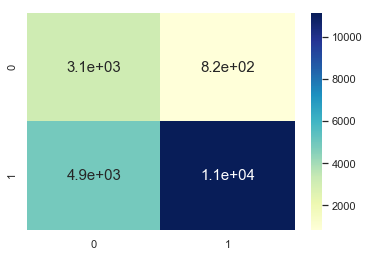

In [96]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

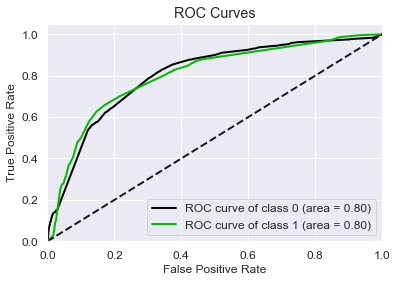

In [97]:
import scikitplot as skplt

predicted_probas = model.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

### Top 25 Bigrams.

In [99]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names), reverse=True)
    top = coefs_with_fns[:n]
    print ("\tTop {} features".format(n))
    print ("\t------------------------")
    for (coef_1, fn_1) in top:
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))
        #print(feature_names)

In [100]:
show_most_informative_features(count_vect, clf, n=25)

	Top 25 features
	------------------------
	0.0960	not            
	0.0697	great          
	0.0596	disappointed   
	0.0452	money          
	0.0445	worst          
	0.0415	best           
	0.0399	not buy        
	0.0298	awful          
	0.0283	not worth      
	0.0274	threw          
	0.0269	not disappointed
	0.0253	not recommend  
	0.0240	refund         
	0.0238	love           
	0.0203	delicious      
	0.0166	disappointing  
	0.0162	terrible       
	0.0122	waste          
	0.0115	horrible       
	0.0108	waste money    
	0.0107	return         
	0.0106	bad            
	0.0078	stale          
	0.0075	disgusting     
	0.0074	disappointment 


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [86]:
clf = DecisionTreeClassifier(max_depth = model.best_params_['max_depth']).fit(X_train, y_train)

In [87]:
from subprocess import check_call
os.environ["PATH"] += os.pathsep + r'C:\Users\avinash\Anaconda3\Library\bin\graphviz'

In [88]:
labels = list(i for i in str(np.unique(y_train)) if i.isnumeric())
labels

['0', '1']

In [89]:
from graphviz import *
dot_data = tree.export_graphviz(clf, out_file=None, max_depth=3, feature_names=count_vect.get_feature_names(), 
                                class_names=labels, filled=True, rounded=True, special_characters=True)
#graph = graphviz.Source(dot_data)
#graph.render('BOW_DT_graphviz',view=True)
#check_call(['dot', '-Tpdf', 'BOW DT graphviz.dot', '-O', 'BOW DT graphviz.png'])

In [90]:
import pydotplus

#dt_graphviz = tree.export_graphviz(clf, out_file = None)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)

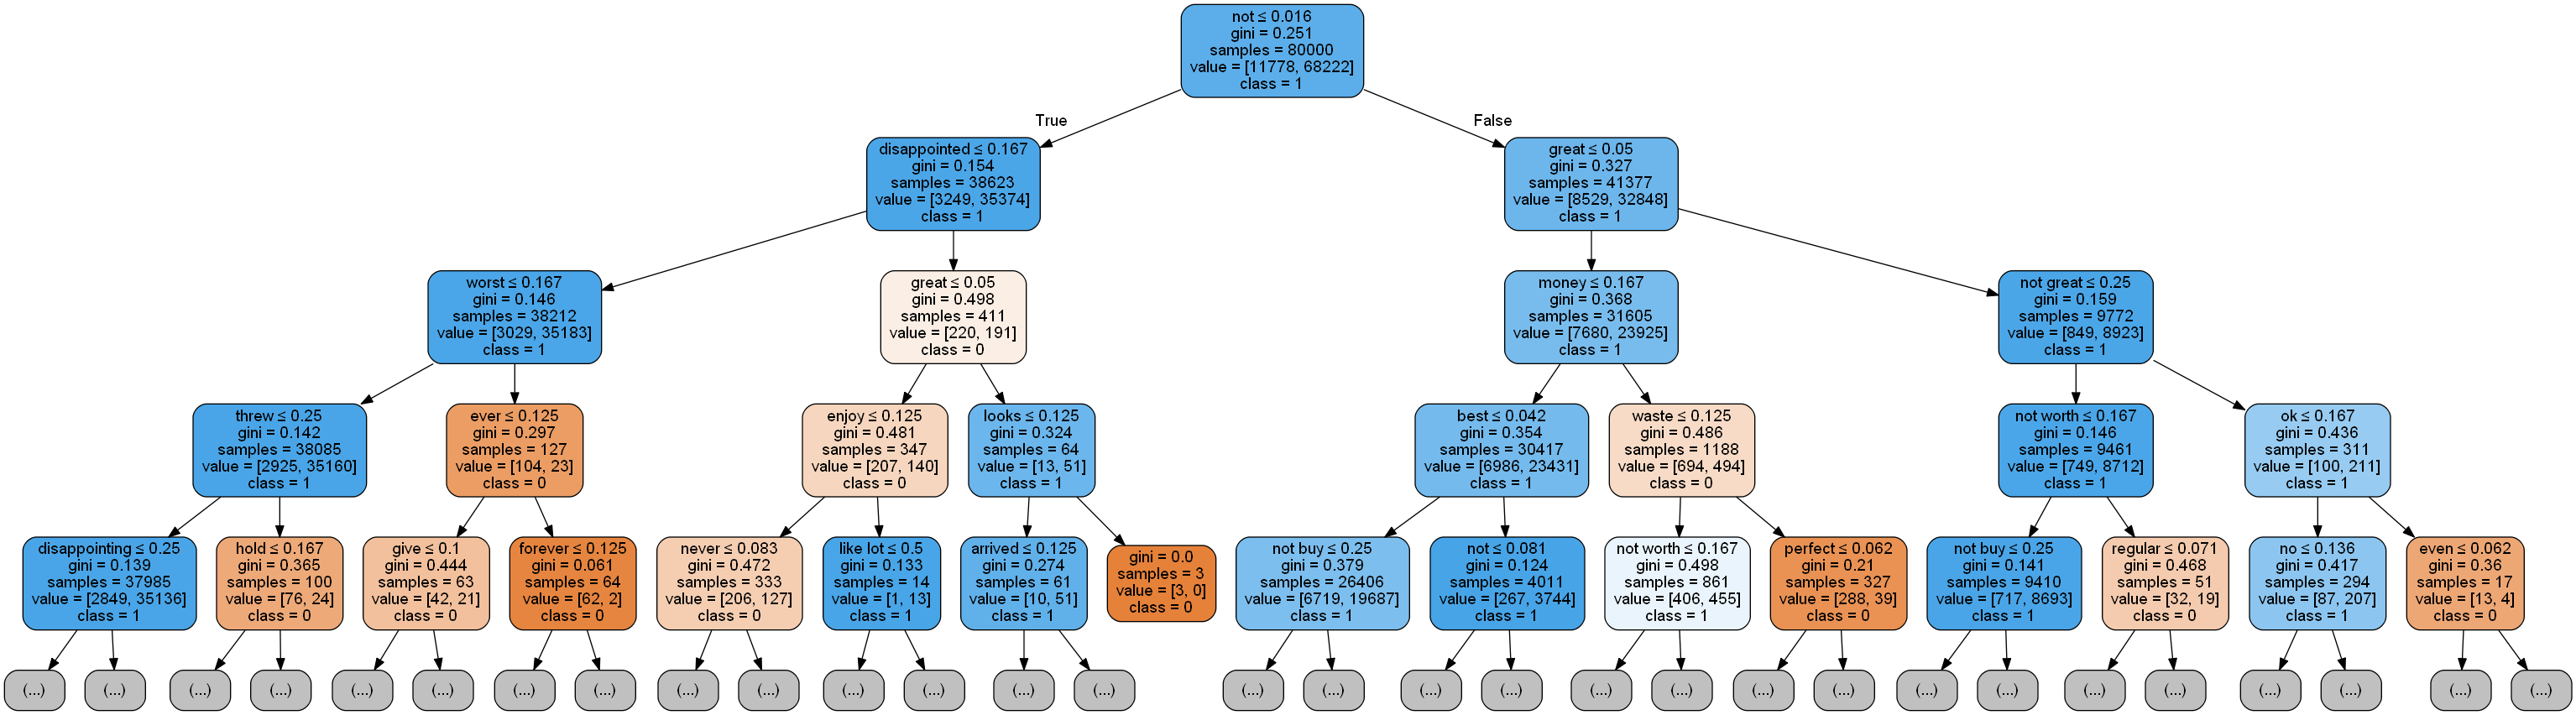

In [91]:
from IPython.display import Image

Image(pydot_graph.create_png(), width=1000, height=400)

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [101]:
openPickleFile("X_train_TFIDF_sparse")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(80000, 5000)
float64


In [102]:
openPickleFile("X_test_TFIDF_sparse")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(20000, 5000)
float64


**RandomizedSearchCV**

In [103]:
y_train =y_train.astype(float)

In [104]:
y_train.dtype

dtype('float64')

In [105]:
time_start = time.time()

tuned_parameters = {'max_depth': [3, 5, 7, 10, 12, 15, 50],
                   'min_samples_split': [5, 10, 100, 500]} #params should be passed as a dict not as list of dict.

clf = DecisionTreeClassifier(class_weight={1:0.1572, 0:0.8428})
#Using RandomizedSearchCV
model = RandomizedSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, n_jobs=6,
                            random_state = 12, n_iter=10, verbose = True)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

print ('CV for Bigrams for varying max_depth and min_sample_split done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   29.9s finished


DecisionTreeClassifier(class_weight={1: 0.1572, 0: 0.8428}, criterion='gini',
            max_depth=15, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.7958687887432916
CV for Bigrams for varying max_depth and min_sample_split done! Time elapsed: 39.06854796409607 seconds


In [106]:
report(model.cv_results_)

Model with rank: 1
Mean validation score: 0.793 (std: 0.005)
Parameters: {'min_samples_split': 100, 'max_depth': 15}

Model with rank: 2
Mean validation score: 0.790 (std: 0.005)
Parameters: {'min_samples_split': 500, 'max_depth': 12}

Model with rank: 3
Mean validation score: 0.782 (std: 0.005)
Parameters: {'min_samples_split': 500, 'max_depth': 10}



In [114]:
# ============================== Decision Tree with max_depth = optimal_max_depth ==============================================
from sklearn.metrics import roc_auc_score
optimal_cv_result = max(model.cv_results_['mean_test_score'])
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of the DT is %f%%' % (acc))

# evaluate accuracy
pred = model.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of the DT for max_depth = %f is %f%%' % (model.best_params_['max_depth'], acc))


The CV AUC score of the DT is 79.281807%

The Test AUC score of the DT for max_depth = 15.000000 is 73.889591%


**Precision, Recall and F1 score report**

In [115]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.38      0.79      0.52      3942
    class 1       0.93      0.69      0.79     16058

avg / total       0.82      0.71      0.74     20000



**Confusion matrix**

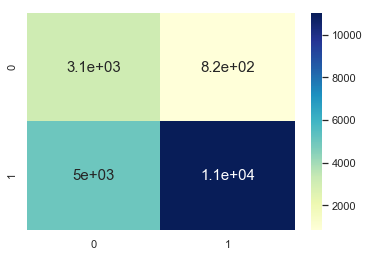

In [116]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

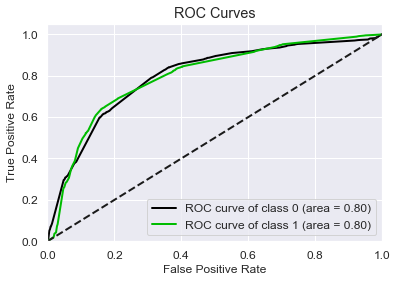

In [117]:
import scikitplot as skplt

predicted_probas = model.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

### Top 25 TFIDF.

In [118]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.feature_importances_, feature_names), reverse=True)
    top = coefs_with_fns[:n]
    print ("\tTop {} features".format(n))
    print ("\t------------------------")
    for (coef_1, fn_1) in top:
        print ("\t%.4f\t%-15s" % (coef_1, fn_1))
        #print(feature_names)

In [119]:
show_most_informative_features(tf_idf_vect, clf, n=25)

	Top 25 features
	------------------------
	0.1302	not            
	0.0666	great          
	0.0630	disappointed   
	0.0527	worst          
	0.0345	best           
	0.0332	not buy        
	0.0328	terrible       
	0.0323	threw          
	0.0323	not disappointed
	0.0281	horrible       
	0.0271	money          
	0.0266	love           
	0.0252	not worth      
	0.0240	refund         
	0.0235	waste money    
	0.0230	awful          
	0.0185	not recommend  
	0.0143	delicious      
	0.0133	disappointing  
	0.0095	bad            
	0.0092	disappointment 
	0.0081	not even       
	0.0072	received       
	0.0064	disgusting     
	0.0063	not great      


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [108]:
clf = DecisionTreeClassifier(max_depth = model.best_params_['max_depth']).fit(X_train, y_train)

In [110]:
labels = list(i for i in str(np.unique(y_train)) if i.isnumeric())
labels

['0', '1']

In [111]:
from graphviz import *
dot_data = tree.export_graphviz(clf, out_file=None, max_depth=3, feature_names=count_vect.get_feature_names(), 
                                class_names=labels, filled=True, rounded=True, special_characters=True)
#graph = graphviz.Source(dot_data)
#graph.render('BOW_DT_graphviz',view=True)
#check_call(['dot', '-Tpdf', 'BOW DT graphviz.dot', '-O', 'BOW DT graphviz.png'])

In [112]:
import pydotplus

#dt_graphviz = tree.export_graphviz(clf, out_file = None)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)

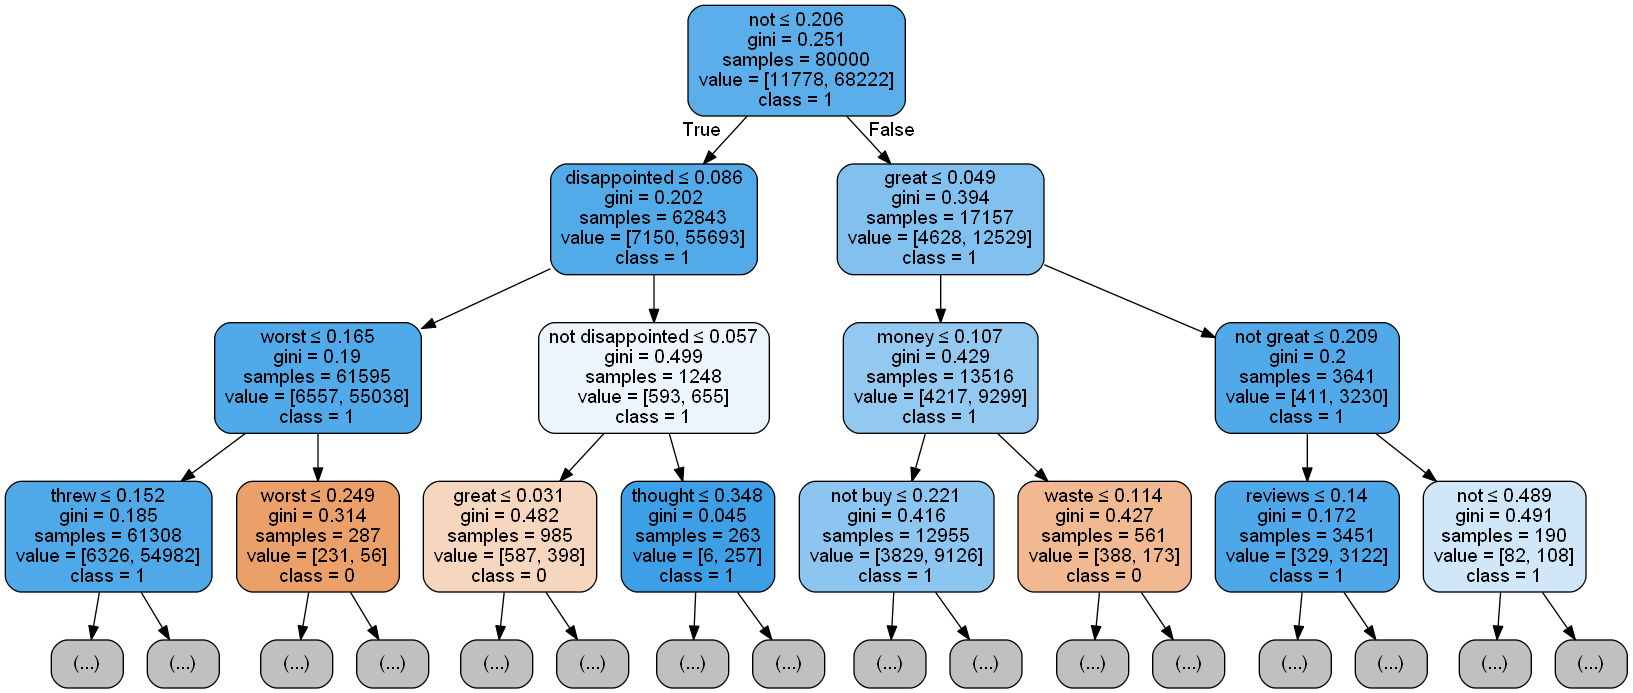

In [113]:
from IPython.display import Image

Image(pydot_graph.create_png(), width=1000, height=400)

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [120]:
openPickleFile("X_train_AVG_W2V_vectors")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(80000, 50)
float64


In [121]:
openPickleFile("X_test_AVG_W2V_vectors")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(20000, 50)
float64


**RandomizedSearchCV**

In [123]:
y_train =y_train.astype(float)

In [124]:
y_train.dtype

dtype('float64')

In [125]:
time_start = time.time()

tuned_parameters = {'max_depth': [3, 5, 7, 10, 12, 15, 50],
                   'min_samples_split': [5, 10, 100, 500]} #params should be passed as a dict not as list of dict.

clf = DecisionTreeClassifier(class_weight={1:0.1572, 0:0.8428})
#Using RandomizedSearchCV
model = RandomizedSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, n_jobs=6,
                            random_state = 12, n_iter=10, verbose = True)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

print ('CV for Bigrams for varying max_depth and min_sample_split done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   25.8s finished


DecisionTreeClassifier(class_weight={1: 0.1572, 0: 0.8428}, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.8219270340348557
CV for Bigrams for varying max_depth and min_sample_split done! Time elapsed: 31.371099948883057 seconds


In [126]:
report(model.cv_results_)

Model with rank: 1
Mean validation score: 0.822 (std: 0.008)
Parameters: {'min_samples_split': 500, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.821 (std: 0.008)
Parameters: {'min_samples_split': 500, 'max_depth': 12}

Model with rank: 3
Mean validation score: 0.820 (std: 0.008)
Parameters: {'min_samples_split': 10, 'max_depth': 7}



In [127]:
# ============================== Decision Tree with max_depth = optimal_max_depth ==============================================
from sklearn.metrics import roc_auc_score
optimal_cv_result = max(model.cv_results_['mean_test_score'])
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of the DT is %f%%' % (acc))

# evaluate accuracy
pred = model.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of the DT for max_depth = %f is %f%%' % (model.best_params_['max_depth'], acc))


The CV AUC score of the DT is 82.198628%

The Test AUC score of the DT for max_depth = 10.000000 is 74.312566%


**Precision, Recall and F1 score report**

In [128]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.43      0.72      0.54      3942
    class 1       0.92      0.76      0.83     16058

avg / total       0.82      0.76      0.78     20000



**Confusion matrix**

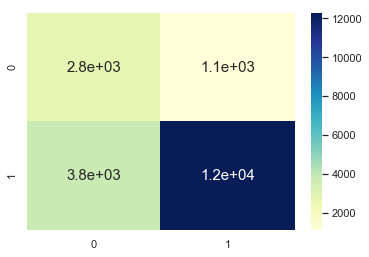

In [129]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

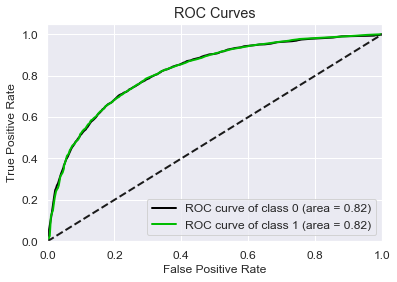

In [130]:
import scikitplot as skplt

predicted_probas = model.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [131]:
openPickleFile("X_train_TFIDF_AvgW2V")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(80000, 50)
float64


In [132]:
openPickleFile("X_test_TFIDF_AvgW2V")
X_test = temp
print(X_test.shape)
print(X_test.dtype)

(20000, 50)
float64


**RandomizedSearchCV**

In [133]:
y_train =y_train.astype(float)

In [134]:
y_train.dtype

dtype('float64')

In [135]:
time_start = time.time()

tuned_parameters = {'max_depth': [3, 5, 7, 10, 12, 15, 50],
                   'min_samples_split': [5, 10, 100, 500]} #params should be passed as a dict not as list of dict.

clf = DecisionTreeClassifier(class_weight={1:0.1572, 0:0.8428})
#Using RandomizedSearchCV
model = RandomizedSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, n_jobs=6,
                            random_state = 12, n_iter=10, verbose = True)
model.fit(X_train, y_train)

print(model.best_estimator_)
print(model.score(X_test, y_test))

print ('CV for Bigrams for varying max_depth and min_sample_split done! Time elapsed: {} seconds'.format(time.time()-time_start))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   26.4s finished


DecisionTreeClassifier(class_weight={1: 0.1572, 0: 0.8428}, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.7881861961070974
CV for Bigrams for varying max_depth and min_sample_split done! Time elapsed: 32.03435182571411 seconds


In [136]:
report(model.cv_results_)

Model with rank: 1
Mean validation score: 0.794 (std: 0.005)
Parameters: {'min_samples_split': 500, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.793 (std: 0.005)
Parameters: {'min_samples_split': 500, 'max_depth': 12}

Model with rank: 3
Mean validation score: 0.787 (std: 0.004)
Parameters: {'min_samples_split': 10, 'max_depth': 7}



In [137]:
# ============================== Decision Tree with max_depth = optimal_max_depth ==============================================
from sklearn.metrics import roc_auc_score
optimal_cv_result = max(model.cv_results_['mean_test_score'])
acc = optimal_cv_result * float(100)
print('\nThe CV AUC score of the DT is %f%%' % (acc))

# evaluate accuracy
pred = model.predict(X_test)
acc = roc_auc_score(y_test, pred) * 100
print('\nThe Test AUC score of the DT for max_depth = %f is %f%%' % (model.best_params_['max_depth'], acc))


The CV AUC score of the DT is 79.438768%

The Test AUC score of the DT for max_depth = 10.000000 is 71.328740%


**Precision, Recall and F1 score report**

In [138]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test, pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.40      0.68      0.50      3942
    class 1       0.90      0.75      0.82     16058

avg / total       0.80      0.73      0.76     20000



**Confusion matrix**

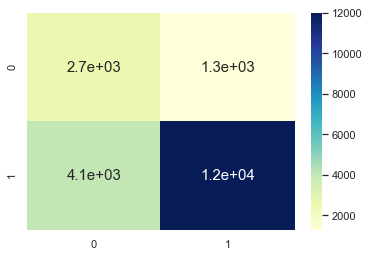

In [139]:
import seaborn as sns; sns.set()
cnf_matrix = confusion_matrix(y_test, pred)

df_cm = pd.DataFrame(cnf_matrix)

#sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 15},cmap="YlGnBu")# font size and colors selection.

**ROC AUC curve**

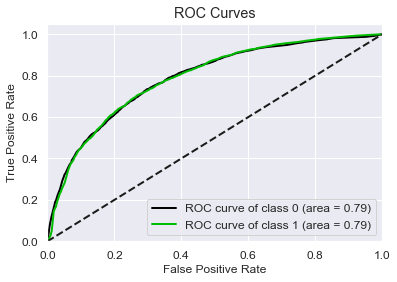

In [140]:
import scikitplot as skplt

predicted_probas = model.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, predicted_probas, plot_micro=False, plot_macro=False)
plt.show()

# [6] Conclusions

In [143]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]

x.add_row(["BOW(Bigrams)", "DTClassifier", "tol=1e-20", 0.80])
x.add_row(["TFIDF", "DTClassifier", "tol=1e-20", 0.80])
x.add_row(["Avg W2V", "DTClassifier", "tol=1e-20", 0.82])
x.add_row(["TFIDF Avg W2V", "DTClassifier", "tol=1e-20", 0.79])

print(x)

+---------------+--------------+----------------+------+
|   Vectorizer  |    Model     | Hyperparameter | AUC  |
+---------------+--------------+----------------+------+
|  BOW(Bigrams) | DTClassifier |   tol=1e-20    | 0.8  |
|     TFIDF     | DTClassifier |   tol=1e-20    | 0.8  |
|    Avg W2V    | DTClassifier |   tol=1e-20    | 0.82 |
| TFIDF Avg W2V | DTClassifier |   tol=1e-20    | 0.79 |
+---------------+--------------+----------------+------+
